# [Advent of Code 2018](https://adventofcode.com/2018)

- [Day 1](#Day-1-Chronal-Calibration) Chronal Calibration
- [Day 2](#Day-2-Inventory-Management-System) Inventory Management System
- [Day 3](#Day-3-No-Matter-How-You-Slice-It)  No Matter How You Slice It
- [Day 4](#Day-4-Repose-Record) Repose Record
- [Day 5](#Day-5-Alchemical-Reduction) Alchemical Reduction
- [Day 6](#Day-6-Chronal-Coordinates) Chronal Coordinates
- [Day 7](#Day-7-The-Sum-of-Its-Parts) The Sum of Its Parts
- [Day 8](#Day-8-Memory-Maneuver) Memory Maneuver
- [Day 9](#Day-9-Marble-Mania) Marble Mania
- [Day 10](#Day-10-The-Stars-Align) The Stars Align
- [Day 11](#Day-11-Chronal-Charge) Chronal Charge
- [Day 12](#Day-12-Subterranean-Sustainability) Subterranean Sustainability
- [Day 13](#Day-13-Mine-Cart-Madness) Mine Cart Madness
- [Day 14](#Day-14-Chocolate-Charts) Chocolate Charts
- [Day 15](#Day-15)
- [Day 16](#Day-16-Chronal-Classification) Chronal Classification
- [Day 17](#Day-17-Reservoir-Research) Reservoir Research
- [Day 18](#Day-18-Settlers-of-The-North-Pole) Settlers of The North Pole
- [Day 19](#Day-19-Go-With-The-Flow) Go With The Flow
- [Day 20](#Day-20)
- [Day 21](#Day-21)
- [Day 22](#Day-22-Mode-Maze) Mode Maze
- [Day 23](#Day-23-Experimental-Emergency-Teleportation) Experimental Emergency Teleportation
- [Day 24](#Day-24)
- [Day 25](#Day-25-Four-Dimensional-Adventure) Four Dimensional Adventure

I'm going to have a go at the Advent of Code 2018 puzzles using a Jupyter notebook.
First, let's import some standard modules.

In [1]:
import collections
import functools
import itertools as its
import math
import operator
import re
import string
from pprint import pprint

Also, here are some general purpose functions.

In [2]:
def day(day):
    'Load the input for `day`'
    return open(f'input/{day}').read()

def ilen(xs):
    'Return the length of an iterable'
    return sum(1 for _ in iter(xs))

def last(xs):
    'Return the last element of an iterable sequence.'
    xs = iter(xs)
    return collections.deque(xs, maxlen=1)[0]

def ints(s):
    'Return a tuple of integer tokens in `s`.'
    return tuple(int(x) for x in re.findall(r'[-+]?\d+', s))

def array(data):
    'Convert the data into a tuple of int-tuples.'
    return tuple(ints(line) for line in data.splitlines())

def swap(xs, i, j):
    'Swap items in a sequence.'
    xs[i], xs[j] = xs[j], xs[i]

def nth(xs, n):
    'Return the nth element of a sequence.'
    return next(its.islice(xs, n, None))

def take(xs, n=None):
    '''Return (up to) first `n` items of a sequence
    or the whole sequence if `n` is `None`
    '''
    return list(xs) if n is None else [x for x, _ in zip(xs, range(n))]

def overlapping(xs, n):
    '''Generate overlapping n-tuples from `xs`

    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG
    '''
    if isinstance(xs, collections.abc.Sequence):
        yield from (xs[i:i+n] for i in range(len(xs) + 1 - n))
    else:
        result = collections.deque(maxlen=n)
        for x in xs:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    's -> (s0,s1), (s1,s2), (s2, s3), ...'
    return overlapping(iterable, 2)

def unfold(fn, x):
    while True:
        yield x
        x = fn(x)

def chunked(xs, n):
    'Collect `xs` into chunks of length `n`'
    return zip(*[iter(xs)] * n)

def manhattan_distance(P, Q):
    'Return the city block distance from `P` to `Q`'
    return sum(math.fabs(p-q) for p,q in zip(P, Q))

def neighbours4(x, y):
    'Return the horizontal and vertical neighbours of `(x, y)`'
    return (x,y-1),(x-1,y),(x+1,y),(x,y+1)

def neighbours8(x, y):
    'Return the horizontal, vertical and diagonal neighbours of `(x, y)`'
    return ((x-1,y-1),(x-1,y),(x-1,y+1),
            (x,y-1),(x,y+1),
            (x+1,y-1),(x+1,y),(x+1,y+1))

def unique(xs):
    'Return `True` iff no elements of `xs` are repeated'
    return len(xs) == len(set(xs))

def mapt(f, xs):
    return tuple(map(f, xs))

def render_grid(grid, fill_ch=' '):
    '''Convert `grid` into a printable form
    
    grid - maps 2D points to single chars
    fill_ch - used for chars not in the grid
    '''
    xlo, xhi = min(map(first, grid)), max(map(first, grid))
    ylo, yhi = min(map(second, grid)), max(map(second, grid))
    return ncat(cat(grid.get((x,y), fill_ch)
                    for x in range(xlo, xhi+1))
                for y in range(ylo, yhi+1))

def draw_grid(grid, fill_ch=' '):
    print(render_grid(grid, fill_ch))       

flatten = its.chain.from_iterable
cat = ''.join
ncat = '\n'.join
first = operator.itemgetter(0)
second = operator.itemgetter(1)

## [Day 1](https://adventofcode.com/2018/day/1) Chronal Calibration
The input is a series of integers, one per line. These integers represent frequency deltas. Part one requires the final frequency. That is, the sum of these integers.

In [3]:
deltas = ints(day(1)) 
sum(deltas)

599

Part two explains the frequency deltas cycle repeatedly. We are asked to find the first frequency which is reached a second time.

In [4]:
seen = set()
for freq in its.accumulate(its.cycle(deltas)):
    if freq in seen:
        break
    seen.add(freq)

freq

81204

## [Day 2](https://adventofcode.com/2018/day/2) Inventory Management System
The input is a list of strings representing box ids.

In [5]:
box_ids = day(2).split()

We need to know the counts of letters in these ids -- specifically, how many ids have letters repeated 2 and/or 3 times? `Counter` can help here.

In [6]:
box_counts = [collections.Counter(box_id) for box_id in box_ids]
x2 = sum(2 in box_count.values() for box_count in box_counts)
x3 = sum(3 in box_count.values() for box_count in box_counts)

We're asked for the product of the repeat counts.

In [7]:
x2 * x3

5681

Part two asks for something quite different: to identify a pair of ids which differ by a single character.

In [8]:
len(box_ids)

250

For such a low number of ids, we simply check every pair.

In [9]:
def diffs(b, B):
    'Return the number of characters which differ in the inputs'
    return sum(c != C for c, C in zip(b, B))

diff_by_one = [p for p in its.combinations(box_ids, 2) if diffs(*p) == 1]

# Check there's just one pair which fits the criteria
assert len(diff_by_one) == 1

We're asked for the letters common to this pair.

In [10]:
''.join(c for c, C in zip(*diff_by_one[0]) if c == C)

'uqyoeizfvmbistpkgnocjtwld'

## [Day 3](https://adventofcode.com/2018/day/3) No Matter How You Slice It
This puzzle is about *claim*s, which are regions in a grid. Each grid square is specified by an id, then left, top, width, height values. We could write a regex to parse/check, but simply extracting `ints` gets us there.

In [11]:
claim = "#123 @ 3,2: 5x4"
ints(claim) 

(123, 3, 2, 5, 4)

For part one, we want to know how many squares on the grid are covered by more than one claim. Let's find the total area of all the claims.

In [12]:
claims = array(day(3))
sum(c[3]*c[4] for c in claims)

492476

Given this figure, we can just count the number of claims in each cell. We can then read the number of squares with 2 or more claims.

In [13]:
def rectangle(id_, L, T, W, H):
    'Generate the points within a claim'
    return its.product(range(L, L+W), range(T, T+H))

grid = collections.Counter(
    p for claim in claims for p in rectangle(*claim))

sum(N > 1 for N in grid.values())

112378

For part two, we want the id of the claim which doesn't overlap any other claim. That's the claim for which cell counts are all `1`.

In [14]:
non_overlaps = [claim[0] for claim in claims
                if all(grid[p] == 1 for p in rectangle(*claim))]

assert len(non_overlaps) == 1, "Multiple answers to Day 3 part 2"
non_overlaps[0]

603

## [Day 4](https://adventofcode.com/2018/day/4) Repose Record
It's not entirely clear what's wanted here. Are we only concerned with guards being asleep during the midnight hour? Or, when we sort the inputs, are these the only times guards are asleep? Let's investigate by sorting the records, noting that the result is time-ordered.

In [15]:
! sort < input/4

[1518-01-29 23:57] Guard #2417 begins shift
[1518-01-30 00:13] falls asleep
[1518-01-30 00:50] wakes up
[1518-01-31 00:00] Guard #1301 begins shift
[1518-01-31 00:24] falls asleep
[1518-01-31 00:54] wakes up
[1518-01-31 23:59] Guard #401 begins shift
[1518-02-01 00:42] falls asleep
[1518-02-01 00:51] wakes up
[1518-02-02 00:03] Guard #2207 begins shift
[1518-02-02 00:10] falls asleep
[1518-02-02 00:49] wakes up
[1518-02-03 00:03] Guard #3541 begins shift
[1518-02-03 00:22] falls asleep
[1518-02-03 00:56] wakes up
[1518-02-04 00:03] Guard #2207 begins shift
[1518-02-04 00:09] falls asleep
[1518-02-04 00:26] wakes up
[1518-02-04 00:42] falls asleep
[1518-02-04 00:58] wakes up
[1518-02-05 00:00] Guard #2663 begins shift
[1518-02-05 00:44] falls asleep
[1518-02-05 00:50] wakes up
[1518-02-05 23:57] Guard #2207 begins shift
[1518-02-06 00:54] falls asleep
[1518-02-06 00:59] wakes up
[1518-02-07 00:00] Guard #1301 begins shift
[1518-02-07 00:44] falls asleep
[1518-02-07 00:53] wakes up
[1518

Now my questions about the input are clarified. Every night just a single guard is on duty and that guard only sleeps during the midnight hour.

We scan through the sorted records and keep a counter for each guard. That counter records minutes in the midnight hour the guard was asleep. For example, `sleeping[42][5] == 3` would mean guard `#42` was asleep on 3 nights between `00:05` and `00:06`.

In [16]:
sleeping = collections.defaultdict(collections.Counter)

for record in sorted(day(4).splitlines()):
    yy,mm,dd,hh,mm,*rest = ints(record)
    if 'shift'  in record:
        guard = rest[0]
    elif 'asleep' in record:
        assert hh == 0, f"Guard falls asleep at time {hh}:{mm}!"
        asleep = mm
    else:
        assert 'wakes' in record, record
        assert hh == 0, f"Guard wakes at time {hh}:{mm}!"
        sleeping[guard].update(range(asleep, mm))

# Let's have a look at some data & check it looks OK. 
sleeping[2417].most_common(5) # Guard 2417 is the first in our ordered input

[(39, 10), (40, 10), (41, 10), (42, 10), (36, 9)]

For part one, we're after the guard who slept the longest and the minute they were most often asleep. The answer wanted is the product of the gaurd's id and the minute.

In [17]:
guard, asleep = max(sleeping.items(), key=lambda i: sum(i[1].values()))
asleep.most_common(2)

[(45, 15), (44, 14)]

That's good -- we have a unique choice for the minute the guard was most often asleep. We can get the answer directly.

In [18]:
guard * asleep.most_common(1)[0][0]

119835

Part two asks: Of all guards, which guard is most frequently asleep on the same minute? The answer is in our `sleeping` dict.

In [19]:
def sleepiest_minute(guard_mins):
    guard, mins = guard_mins
    minute, freq = mins.most_common(1).pop()
    return freq, minute, guard

freq, minute, guard = max(map(sleepiest_minute, sleeping.items()))
guard * minute

12725

## [Day 5](https://adventofcode.com/2018/day/5) Alchemical Reduction
Pairs of characters are repeatedly removed from a polymer -- represented as a string. First, find all possible pairs, and create a function to destroy these pairs.

In [20]:
import string
az, AZ = string.ascii_lowercase, string.ascii_uppercase
removes = [cat(p) for p in zip(az, AZ)] + [cat(p) for p in zip(AZ, az)]
react_sub = re.compile('|'.join(removes)).sub

def react_fn(s):
    return react_sub('', s)

assert react_fn('abBA') == 'aA'

Now we keep processing the polymer until there's nothing to remove.

In [21]:
def react(polymer, react_fn=react_fn):
    'Apply `react_fn` until `polymer` stabilises, returning the stable form'
    return next(p for p, n in pairwise(unfold(react_fn, polymer))
                if p == n)

assert react('dabAcCaCBAcCcaDA') == 'dabCBAcaDA'

polymer = day(5).strip() # (strip in case a newline appeared in the file)
%time len(react(polymer))

Wall time: 3.81 s


9562

For part two, we see what happens if we remove all instances of a unit before reacting. Which unit results in the biggest reaction?

In [22]:
inputs = (re.sub(x, '', polymer, re.I) for x in AZ)
%time min(len(react(p)) for p in inputs)

Wall time: 1min 42s


9560

## [Day 6](https://adventofcode.com/2018/day/6) Chronal Coordinates
We are filling an infinite grid, stepping in horizontal or vertical direction. 

In [23]:
coords = set(ints(row) for row in day(6).splitlines())

# Find the X and Y ranges of the pts
x, X = min(map(first,  coords)), max(map(first,  coords))
y, Y = min(map(second, coords)), max(map(second, coords))

def on_edge(pt):
    'Return `True` if `pt` is on the bounding box of `coords`'
    return pt[0] in {x, X} or pt[1] in {y, Y}

def closest(pt, coords, dist=manhattan_distance):
    'Return the `coords` closest to `pt`'
    def key(p): return dist(p, pt)
    d, result = next(its.groupby(sorted(coords, key=key), key=key))
    return tuple(result)

# Find the closest coord to each point in the bounding box of `coords`
closest_coords = {p: closest(p, coords) 
                  for p in its.product(range(x, X+1), range(y, Y+1))}

# We are looking for the coord surrounded by the largest contained region. 

# We can eliminate any coord which is closest to a point on 
# the bounding box -- such points are not contained
infinite_extent = set(
    flatten(vs for p, vs in closest_coords.items() if on_edge(p)))

# Now count up points closest to `coords` -- this gives us areas of
# contained regions
areas = collections.Counter(
    v for v, *tied in closest_coords.values()
    if not tied and v not in infinite_extent)

coord, biggest_area = areas.most_common(1)[0]
biggest_area

3894

For part two, we want to find the region in which all points have a total Manhattan distance from `pts` of less than 10000.

In [24]:
min(sum(manhattan_distance(p, q) for q in coords) 
    for p in closest_coords if on_edge(p)) 

11299.0

Since 11299 > 10000, this check confirms the region is strictly within the bounding box of the coords.

In [25]:
ilen(p for p in its.product(range(x, X+1), range(y, Y+1))
     if sum(manhattan_distance(p, q) for q in coords) < 10000)

39398

## [Day 7](https://adventofcode.com/2018/day/7) The Sum of Its Parts
Part one is a topological sort, with the minor twist of ordering dependencies alphabetically when there's a choice.

In [26]:
# Each row in the input looks something like
row = 'Step Y must be finished before step J can begin.'
# We can extract the dependency like this
select = operator.itemgetter(1, 7)
select(row.split())

('Y', 'J')

In [27]:
edges = sorted(select(row.split()) for row in day(7).splitlines())

graph = collections.defaultdict(list,
    {v: mapt(second, deps) for v, deps in its.groupby(edges, key=first)})

in_degrees = collections.Counter(map(second, edges))
ready = set(graph) - set(in_degrees)
topo = []
while ready:
    v = min(ready)
    topo.append(v)
    ready.remove(v)
    in_degrees.subtract(collections.Counter(graph[v]))
    ready |= {v for v, n in in_degrees.items() 
              if n==0 and v not in topo}
    
cat(topo)

'CHILFNMORYKGAQXUVBZPSJWDET'

Part two adds extra workers (elves) and assigns times to the steps. We are asked for the time to complete the tasks.

In [28]:
in_degrees = collections.Counter(map(second, edges))
ready = set(graph) - set(in_degrees)
workers = 5

def t_step(S):
    'Step A takes 61 seconds, B 62 seconds etc.'
    return 61 + ord(S) - ord('A')

t = 0
work = []
topo = []

while ready or work:
    if ready and workers:
        workers -= 1
        v = min(ready)
        ready.remove(v)
        work.append((t + t_step(v), v))
    else:
        workers += 1
        work.sort(reverse=True)
        t, v = work.pop()
        topo.append(v)
        in_degrees.subtract(collections.Counter(graph[v]))
        ready |= {v for v, n in in_degrees.items() 
                  if n==0 and v not in topo and v not in mapt(second, work)}

t

891

## [Day 8](https://adventofcode.com/2018/day/8) Memory Maneuver
A list of integers defines a tree structure. Part one asks us to total up the metadata stored in the tree nodes.

In [29]:
def traverse(tree_data, i, metadata_callback):
    '''Traverse `tree_data` from index `i` calling `metadata_callback`
    
    Returns the index into `tree_data` after traversing
    '''
    # Read the header ...
    children, metas = tree_data[i], tree_data[i+1]
    i += 2
    # ... and the children
    for _ in range(children):
        i = traverse(tree_data, i, metadata_callback)
    # ... and metadata
    metadata_callback(tree_data[i: i+metas])
    return i + metas

metadata = []

# Check the example
traverse(ints('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 0, metadata.extend)
assert sum(metadata) == 138

metadata.clear()
traverse(ints(day(8)), 0, metadata.extend)
sum(metadata)

44838

Part two asks for the value of the root node, which is recursively evaluated from its children, considering the metadata as indices into these children.

In [30]:
def tree_value(tree_data, i):
    children, metas = tree_data[i], tree_data[i+1]
    i += 2
    child_values = {}
    for j in range(children):
        i, v = tree_value(tree_data, i)
        child_values[j+1] = v
    
    md = tree_data[i: i+metas]
    if children:
        value = sum(child_values.get(m, 0) for m in md)
    else:
        value = sum(md)
    return i + metas, value

assert tree_value(ints('2 3 0 3 10 11 12 1 1 0 1 99 2 1 1 2'), 0)[1] == 66
tree_value(ints(day(8)), 0)[1]

22198

## [Day 9](https://adventofcode.com/2018/day/9) Marble Mania
Inserting numbers into a circular buffer, following some bizarre rules.

In [31]:
def play_marbles():
    marbles, pos = [0], 0
    for N in its.count(1):
        if N % 23:
            pos = (pos + 2) % len(marbles)
            marbles.insert(pos, N)
            yield 0
        else:
            pos = (pos - 7) % len(marbles)
            yield N + marbles.pop(pos)

def marbles_game(players, marbles):
    scores = collections.Counter()
    for score, player in zip(
        its.islice(play_marbles(), marbles), its.cycle(range(players))):
        scores[player] += score
    return max(scores.values())

assert marbles_game(10, 1618) == 8317
assert marbles_game(13, 7999) == 146373
assert marbles_game(17, 1104) == 2764
assert marbles_game(30, 5807) == 37305

In [32]:
# My input: 413 players; last marble is worth 71082 points
%time marbles_game(413, 71082)

Wall time: 622 ms


416424

For the second part, I wrote a [C++ program](./day9/main.cpp) using a doubly-linked list so I could insert and delete nodes in constant time. This gave the answer `3498287922`.

## [Day 10](https://adventofcode.com/2018/day/10) The Stars Align
Points move in a grid until they form a message.

In [33]:
pts_vs = array(day(10))

def lights(pts_vs):
    'Generate the light positions from the `pts_vs` point+velocity 4-tuples.'
    posns = [(its.count(x, vx), its.count(y, vy)) for x, y, vx, vy in pts_vs]
    while True:
        yield [(next(x), next(y)) for x, y in posns]

def bounding_box(pts):
    'Return the axis-aligned box which bounds `pts` as an X-range, Y-range pair'
    xs, ys = mapt(first, pts), mapt(second, pts)
    return range(min(xs), max(xs)+1), range(min(ys), max(ys)+1)

def area(box):
    w, h = box
    return len(w) * len(h)

this_pts, next_pts = its.tee(lights(pts_vs))
next(next_pts)

# We'll assume the message appears when the bounding box of 
# the points reaches a minimum -- when we print the result
# we'll know if we were right :-)
for seconds, (this, next_) in enumerate(zip(this_pts, next_pts)):
    if area(bounding_box(this)) < area(bounding_box(next_)):
        break

# Check the bounding box looks sane
bounding_box(this)

(range(141, 203), range(133, 143))

In [34]:
# Yes, that looks good. Render the message
draw_grid({p: '*' if p in this else ' '
          for p in its.product(*bounding_box(this))})

******  *****   *****   *****   *****   *****   ******    **  
*       *    *  *    *  *    *  *    *  *    *       *   *  * 
*       *    *  *    *  *    *  *    *  *    *       *  *    *
*       *    *  *    *  *    *  *    *  *    *      *   *    *
*****   *****   *****   *****   *****   *****      *    *    *
*       *       *  *    *    *  *  *    *  *      *     ******
*       *       *   *   *    *  *   *   *   *    *      *    *
*       *       *   *   *    *  *   *   *   *   *       *    *
*       *       *    *  *    *  *    *  *    *  *       *    *
*       *       *    *  *****   *    *  *    *  ******  *    *


Part two of the question asks how long it would take to get this answer. I went back and modified my `for` loop to enumerate the zipped values, making the answer available.

In [35]:
seconds

10027

## [Day 11](https://adventofcode.com/2018/day/11) Chronal Charge
We are asked to find the 3x3 square in a 300x300 grid with the largest total power level. 

In [36]:
# The power level for cell (x, y) is calculated from its coords
# and a "serial number"
def hundreds(n):
    'Return the hundreds digit in the decimal representation of `n`'
    return (n//100)%10

def power_level(serial_number, x, y):
    rack_id = x + 10
    return hundreds((rack_id*y + serial_number)*rack_id) - 5

assert power_level(8, 3, 5) == 4
assert power_level(71, 101, 153) == 4

In [37]:
def power_levels(serial_number, S):
    'Calculate power levels for square side `S` using supplied `serial_number`'
    return {p: power_level(serial_number, *p) 
            for p in its.product(range(1, S+1), repeat=2)}
    
def max_power_cell(serial_number, s, S):
    '''Maximise the power for a square side `s`
    
    Returns the cell at the top-left of the `s` square
    - serial_number
    - s, the side legth
    - S, side length of the whole grid
    '''
    levels = power_levels(serial_number, S)
    def total_power(x, y):
        sq = its.product(range(x, x+s), range(y, y+s))
        return sum(levels[p] for p in sq)

    return max(
        (p for p in its.product(range(1,1+S-s), repeat=2)),
        key=lambda p: total_power(*p))

s, S = 3, 300
serial_number = 5468
assert max_power_cell(18, s, S) == (33, 45)
%time max_power_cell(5468, s, S)

Wall time: 402 ms


(243, 64)

In [38]:
def draw_cells(cells):
    'Draw the square grid of `cells`'
    S = int(math.sqrt(len(cells)))
    R = range(1, S+1)
    print(ncat(cat(f'{cells[(x,y)]:3}' for x in R) for y in R))

draw_cells(power_levels(6, 4))

 -4 -3 -3 -3
 -2 -2 -1 -1
 -1  0  0  1
  0  1  2  3


For the second part of the question, we want to maximise the power in a square region over all possible square side lengths `s`. We start by accumulating the power over the grid. 

In [39]:
def cumulative_power(serial_number, S):
    cells = power_levels(serial_number, S)
    R = range(1, S+1)
    # Accumulate rows top-to-bottom
    for y in R[1:]:
        cells.update({(x,y): cells[x,y]+cells[x,y-1] for x in R})

    # Accumulate columns left-to-right
    for x in R[1:]:
        cells.update({(x,y): cells[x,y]+cells[x-1,y] for y in R})
    
    return collections.Counter(cells)

draw_cells(power_levels(6,4))
print()
draw_cells(cumulative_power(6, 4))

 -4 -3 -3 -3
 -2 -2 -1 -1
 -1  0  0  1
  0  1  2  3

 -4 -7-10-13
 -6-11-15-19
 -7-12-16-19
 -7-11-13-13


Using the cumulative power grid we can read out the total power for a rectangular region.

In [40]:
def region_power(accu, t, l, b, r):
    '''Return the total power for a rectangular region
    
    accu - the cumulative powers over the grid
    tl - top-left corner
    br - bottom-right corner (included)
    '''
    return accu[(r,b)] - accu[(r,t-1)] - accu[(l-1,b)] + accu[(l-1,t-1)]

accu = cumulative_power(6, 4)
assert region_power(accu, 1, 1, 1, 1) == -4
assert region_power(accu, 1, 1, 3, 2) == -12

In [41]:
def highest_powered_square(serial_number, S):
    R = range(S+1)
    accu = cumulative_power(serial_number, S)
    def square_power(lts):
        left, top, side = lts
        return region_power(accu, top, left, top+side-1, left+side-1)
    return max(
        ((left, top, side)
        for side in range(1, S+1)
        for top, left in its.product(range(1, S-side+2), repeat=2)),
        key=square_power)

# Check the supplied example answers
assert highest_powered_square(18, 300) == (90, 269, 16)
assert highest_powered_square(42, 300) == (232, 251, 12)

print(serial_number, S)
%time highest_powered_square(serial_number, S)

5468 300
Wall time: 16.5 s


(90, 101, 15)

## [Day 12](https://adventofcode.com/2018/day/12) Subterranean Sustainability
This looks like a one dimensional [game of life](http://wordaligned.org/life).

In [42]:
def parse_input(data):
    'Read initial state and rules'
    rules = {}
    for line in data.splitlines():
        if 'initial state' in line:
            state = line.split()[2]
        elif '=>' in line:
            src, _, dst = line.split()
            rules[src] = dst
    return state, rules

def trim(state, pos0):
    begin, end = state.find('#'), state.rfind('#')
    return state[begin:end+1], pos0-begin

def grow_plants(state, rules):
    pos0 = 0
    while True:
        state, pos0 = trim(state, pos0)
        yield state, pos0
        # Pad the state with enough blanks to apply the rules
        padded = '....' + state + '....'
        state = cat(rules.get(padded[p:p+5], '.') for p,c in enumerate(padded[2:-2]))
        pos0 += 2

example_setup = '''\
initial state: #..#.#..##......###...###

...## => #
..#.. => #
.#... => #
.#.#. => #
.#.## => #
.##.. => #
.#### => #
#.#.# => #
#.### => #
##.#. => #
##.## => #
###.. => #
###.# => #
####. => #'''

# Let's check the output against the example shown
state, rules = parse_input(example_setup)
print('\n'.join(s for s, _ in take(grow_plants(state, rules), 5)))

#..#.#..##......###...###
#...#....#.....#..#..#..#
##..##...##....#..#..#..##
#.#...#..#.#....#..#..#...#
#.#..#...#.#...#..#..##..##


In [43]:
def sum_of_plant_positions(setup, time):
    plants = grow_plants(*parse_input(setup))
    state, pos0 = next(its.islice(plants, time, None))
    return sum(i - pos0 for i, c in enumerate(state) if c == '#')

assert sum_of_plant_positions(example_setup, 20) == 325
sum_of_plant_positions(day(12), 20)

2040

For part two, we're asked for the value returned by `sum_of_plant_positions()` when `time=50_000_000_000`. This is way too big to run directly. Let's see if the pattern repeats.

In [44]:
def repeat(setup):
    '''Grow plants from initial setup until a state repeats
    
    Returns (state, time of repeat, pos0 at repeat, time first seen, pos0 first seen)
    '''
    seen = {}
    for t, (state, pos0) in enumerate(grow_plants(*parse_input(setup))):
        if state in seen:
            return (state, t, pos0, *seen[state])
        seen[state] = t, pos0

state, t_repeat, pos0_repeat, t_first_seen, pos0_first_seen = repeat(day(12))
print(t_repeat, pos0_repeat, t_first_seen, pos0_first_seen)

192 -96 191 -95


This tells us the state at time `192` is the same as the state at time `191`, shifted one to the left. Now we can figure out the state at `time=50_000_000_000`.

In [45]:
T = 50_000_000_000
pos0 = -96 - T + 192
sum(i - pos0 for i, c in enumerate(state) if c == '#')

1700000000011

## [Day 13](https://adventofcode.com/2018/day/13) Mine Cart Madness
Carts are moving round a grid, according to simple rules. The challenge for part one is to locate the first collision. This can be done by reading in the initial set up and then applying the rules to simulate the carts' movements.

In [46]:
# Complex numbers can be used to represent both position and direction.

# Directions to step
N, E, S, W = -1j, 1, 1j, -1
# Ways to turn through 90 degrees
# Note: multiplying a direction by a turn effects that turn
LEFT, AHEAD, RIGHT = -1j, 1, 1j 

class Cart:
    'A cart on a grid'

    def __init__(self, pos, dir_):
        'Initialise, given position and direction'
        self.pos = pos
        self.dir = dir_
        self.turn = its.cycle([LEFT,AHEAD,RIGHT])

    def step(self, track):
        'Step along the track, returning new position'
        self.pos += self.dir
        # Recalculate direction
        at = track[self.pos]
        if   at == '+' : self.dir = next(self.turn) * self.dir
        elif at == '/' : self.dir = {N:E, S:W, W:S, E:N}[self.dir]
        elif at == '\\': self.dir = {N:W, S:E, E:S, W:N}[self.dir]
        return self.pos

    def __lt__(self, o):
        # We need to advance the carts in order
        return (self.pos.imag, self.pos.real) < (o.pos.imag, o.pos.real)
    
    def __str__(self):
        return {N:'^', S:'v', E:'>', W:'<'}[self.dir] 

We need to read in the initial setup.

In [47]:
def read_setup(data):
    'Read the setup from `data`, returning carts and track.'
    cart_to_track = {'^':'|','v':'|','>':'-','<':'-'}
    cart_or_track = set('^v><+|-/\\')
    cart_to_dir = {'^':N, 'v':S, '>':E, '<':W}

    all_ = {complex(x,y): c
            for y, row in enumerate(data.splitlines())
            for x, c in enumerate(row)}

    carts = {Cart(p, cart_to_dir[c]) for p,c in all_.items()
             if c in cart_to_track}

    track = {p: cart_to_track.get(c, c)
             for p,c in all_.items() if c in cart_or_track}

    return carts, track


def draw(carts, track):
    width = int(max(p.real for p in track))
    height = int(max(p.imag for p in track))
    pic = {**track, **{cart.pos: str(cart) for cart in carts}}
    draw_grid({p: pic.get(complex(*p), ' ') 
               for p in its.product(range(width+1), range(height+1))})

example_13 = read_setup(
r'''/->-\        
|   |  /----\
| /-+--+-\  |
| | |  | v  |
\-+-/  \-+--/
  \------/   
''')

draw(*example_13)

/->-\        
|   |  /----\
| /-+--+-\  |
| | |  | v  |
\-+-/  \-+--/
  \------/   


For part one, we want to know where the first crash occurs.

In [48]:
def first_crash(carts, track):
    while True:
        for cart in sorted(carts):
            pos = cart.step(track)
            if ilen(c for c in carts if c.pos == pos) > 1:
                return int(pos.real), int(pos.imag)

assert first_crash(*example_13) == (7, 3)
first_crash(*read_setup(day(13)))

(136, 36)

Part two asks for the position of the final cart after the others have crashed out.

In [49]:
def last_cart_pos(carts, track):
    crashed = set()
    while len(carts) > 1:
        for cart in sorted(carts):
            pos = cart.step(track)
            at_pos = {c for c in carts-crashed if c.pos==pos}
            if len(at_pos) > 1:
                crashed |= at_pos
        carts -= crashed
    assert len(carts) == 1
    pos = carts.pop().pos
    return int(pos.real), int(pos.imag)

example_13_part2 = read_setup(
r'''/>-<\  
|   |  
| /<+-\
| | | v
\>+</ |
  |   ^
  \<->/  
''')

assert last_cart_pos(*example_13_part2) == (6, 4)
print(last_cart_pos(*read_setup(day(13))))

(53, 111)


## [Day 14](https://adventofcode.com/2018/day/14) Chocolate Charts
A pair of elves are inventing recipes, which they do by combining numbers from a list of existing recipes.

In [50]:
def digits(N):
    '''Return a list of the digits in +ve int N
    
    >>> digits(123)
    [1, 2, 3]
    '''
    return [int(d) for d in str(N)]

def generate_recipes(recipes, elf1, elf2):
    '''Generate the list of recipes
    
    - recipes: initial list of recipes
    - elf1, elf2: position of santa's helpers
    '''
    digits_ = [digits(n) for n in range(19)]
    while True:
        yield recipes
        recipes += digits_[recipes[elf1] + recipes[elf2]]
        elf1 = (elf1 + recipes[elf1] + 1) % len(recipes)
        elf2 = (elf2 + recipes[elf2] + 1) % len(recipes)

# Check generate_recipes() matches the supplied example
take(generate_recipes([3, 7], 0, 1), 5)

[[3, 7, 1, 0, 1, 0, 1, 2, 4],
 [3, 7, 1, 0, 1, 0, 1, 2, 4],
 [3, 7, 1, 0, 1, 0, 1, 2, 4],
 [3, 7, 1, 0, 1, 0, 1, 2, 4],
 [3, 7, 1, 0, 1, 0, 1, 2, 4]]

In [51]:
input14 = 540391

We're asked for the 10 recipes which follow the first N, where N is the puzzle input -- in my case, `540391`.

In [52]:
gen = generate_recipes([3, 7], 0, 1)
recipes = next(r for r in gen if len(r) >= input14 + 10)
print(cat(map(str, recipes[input14:input14+10])))

1474315445


Part two asks when we see the recipe sequence formed from the digits of N, the puzzle input.

In [53]:
def day14_part2(input_n):
    gen = generate_recipes([3, 7], 0, 1)
    seq = digits(input_n)
    L = len(seq)
    for recipes in gen:
        if recipes[-L:] == seq: 
            return len(recipes) - L
        if recipes[-L-1:-1] == seq: 
            return len(recipes) - L - 1

assert day14_part2(51589) == 9
assert day14_part2(59414) == 2018

In [54]:
%time day14_part2(input14)

Wall time: 20.4 s


20278122

## [Day 16](https://adventofcode.com/2018/day/16) Chronal Classification
We are given a description of various computer instructions and have to figure out which of them might produce results given a sample showing the register values before and after. I split the input into two sections: part one requires the first only, which is a list of samples, the last of which reads:

In [55]:
! tail -n 3 input/16_part_one

Before: [3, 2, 0, 3]
11 2 0 2
After:  [3, 2, 1, 3]


In [56]:
def load_part_one(data):
    'Load up (before, instruction, after) triples'
    xs = array(data)
    return take(chunked((x for x in xs if x), 3))

samples = load_part_one(open('input/16_part_one').read())
samples[-1]

((3, 2, 0, 3), (11, 2, 0, 2), (3, 2, 1, 3))

We have 16 possible operations on a processor with 4 registers. The operations can be "register" or "immediate", applying to the value in the register specified in the instruction or to the value itself respectively.

In [57]:
def addr(regs, A, B, C): regs[C] = regs[A] +  regs[B]
def addi(regs, A, B, C): regs[C] = regs[A] +       B
def mulr(regs, A, B, C): regs[C] = regs[A] *  regs[B]
def muli(regs, A, B, C): regs[C] = regs[A] *       B
def banr(regs, A, B, C): regs[C] = regs[A] &  regs[B]
def bani(regs, A, B, C): regs[C] = regs[A] &       B
def borr(regs, A, B, C): regs[C] = regs[A] |  regs[B]
def bori(regs, A, B, C): regs[C] = regs[A] |       B
def setr(regs, A, B, C): regs[C] = regs[A]
def seti(regs, A, B, C): regs[C] =      A
def gtir(regs, A, B, C): regs[C] =      A  >  regs[B]
def gtri(regs, A, B, C): regs[C] = regs[A] >       B
def gtrr(regs, A, B, C): regs[C] = regs[A] > regs[B]
def eqir(regs, A, B, C): regs[C] =      A  == regs[B]
def eqri(regs, A, B, C): regs[C] = regs[A] ==      B
def eqrr(regs, A, B, C): regs[C] = regs[A] == regs[B]

all_ops = [
    addr, addi, mulr, muli, banr, bani, borr, bori, setr, seti,
    gtir, gtri, gtrr, eqir, eqri, eqrr
]

Now we've implemented the operators, part one asks how many samples in the puzzle input behave like three or more opcodes?

In [58]:
def valid_for_sample(op, sample):
    'Return `True` iff the op is valid for the sample'
    before, instruction, after = sample
    regs, after = list(before), list(after)
    code, A, B, C = instruction
    op(regs, A, B, C)
    return regs == after

def possible_ops(all_ops, sample):
    'Return the subset of `all_ops` which are valid for the sample'
    return {op for op in all_ops if valid_for_sample(op, sample)}

# Try out the example
assert len(possible_ops(all_ops, ((3, 2, 1, 1), (9, 2, 1, 2), (3, 2, 2, 1)))) == 3

# Now get the answer for part one
ilen(_ for sample in samples if len(possible_ops(all_ops, sample)) >= 3)

580

For part two, we learn the samples are self-consistent, and we can deduce which opcode corresponds to which operator. We need to figure out the mapping `opcode => operation` where `op_code` is the opcode value and `operation` is the function -- one of `all_ops`

In [59]:
def map_code2op(all_ops, samples):
    'Return the {code => op} mapping consistent with samples'
    code2op = {n:set(all_ops) for n in range(16)}
    for sample in samples:
        code = sample[1][0]
        code2op[code] &= possible_ops(all_ops, sample)
    while any(len(ops) > 1 for ops in code2op.values()):
        known_codes = {code for code, ops in code2op.items() if len(ops)==1}
        known_ops = {op for code in known_codes for op in code2op[code]}
        for code in set(code2op) - known_codes:
            code2op[code] -= known_ops
    assert all(len(ops)==1 for ops in code2op.values())
    return {code: ops.pop() for code, ops in code2op.items()}

code2op = map_code2op(all_ops, samples)

Now we're asked to run the program given as the second part of the input, and find the final value of register `0`.

In [60]:
def run_prog(code2op, prog):
    regs = [0, 0, 0, 0]
    for code, A, B, C in prog:
        code2op[code](regs, A, B, C)
    return regs

test_prog = array(open('input/16_part_two').read())
regs = run_prog(code2op, test_prog)
regs[0]

537

## [Day 17](https://adventofcode.com/2018/day/17) Reservoir Research
Water sinks into the ground. It stops when it hits clay. The worked example suggests two modes: 
- fill, when the water is contained by horizontal and vertical bounds
- spill, when the water flows horizontally and down

In [61]:
example_17 = '''\
x=495, y=2..7
y=7, x=495..501
x=501, y=3..7
x=498, y=2..4
x=506, y=1..2
x=498, y=10..13
x=504, y=10..13
y=13, x=498..504'''

def read_ground(data):
    'Reads in the ground, as specified by the example data above'
    ground = collections.defaultdict(lambda: '.')
    fill = ground.update

    for row in data.splitlines():
        v, lo, hi = ints(row)
        if row.startswith('x'): 
            fill(((v,y), '#') for y in range(lo, hi+1))
        elif row.startswith('y'):
            fill(((x,v), '#') for x in range(lo, hi+1))
    
    # Add "!" at the base level so we know when we're in pure sand
    x, X = min(map(first, ground)), max(map(first, ground))
    Y = max(map(second, ground))
    fill(((x, Y+1), '!') for x in range(x-1, X+2))

    return ground

example_ground = read_ground(example_17)
draw_grid(example_ground, '.')

............#.
.#..#.......#.
.#..#..#......
.#..#..#......
.#.....#......
.#.....#......
.#######......
..............
..............
....#.....#...
....#.....#...
....#.....#...
....#######...
!!!!!!!!!!!!!!


Now let's try and implement the fill and spill flow.

In [62]:
def step_L(p): return (left(p, d) for d in its.count())
def step_R(p): return (right(p, d) for d in its.count())
def step_D(p): return (down(p, d) for d in its.count())
def layer(L, R): return ((x, L[1]) for x in range(L[0], R[0]))
def column(T, B): return ((T[0], y) for y in range(T[1], B[1]))

def left (p, d=1): return p[0]-d, p[1]
def right(p, d=1): return p[0]+d, p[1]
def down (p, d=1): return p[0]  , p[1]+d
def up   (p, d=1): return p[0]  , p[1]-d

def water_flow(ground, source):
    ' Model water sinking into `ground`, starting from `source` '
    def stop(p):
        'Should we stop spreading horizontally at `p`?'
        # Yes, if we've hit clay or if there's sand or water beneath
        return ground[p] == '#' or ground[down(p)] in '.|'

    fill = ground.update
    flow_q = {source}
    
    while flow_q:
        source = flow_q.pop()
        # Vertical "Spill": go down until we hit clay/water/baseline
        D = next(d for d in step_D(source) if ground[d] in '#~!')
        fill((d, '|') for d in column(source, D))

        if ground[D] == '!': continue # Bottomed out

        # Horizontal "Fill": spread across left and right
        D = up(D)
        L = next(p for p in step_L(D) if stop(p))
        R = next(p for p in step_R(D) if stop(p))

        if (ground[L], ground[R]) == ('#', '#'):    
            fill((p, '~') for p in layer(right(L), R)) # Fill this level
            flow_q.add(up(D))
        elif ground[L] == '#':                         # Spill right
            fill((p, '|') for p in layer(right(L), right(R)))
            flow_q.add(R)
        elif ground[R] == '#':                         # Spill Left
            fill((p, '|') for p in layer(L, R))
            flow_q.add(L)
        else:
            fill((p, '|') for p in layer(L, right(R))) # Spill both sides
            flow_q |= {L, R}

    return ground

water_source = 500, 0
example_ground = read_ground(example_17)
draw_grid(example_ground)
print()
ground = water_flow(example_ground, water_source)
draw_grid(ground)

            # 
 #  #       # 
 #  #  #      
 #  #  #      
 #     #      
 #     #      
 #######      
              
              
    #     #   
    #     #   
    #     #   
    #######   
!!!!!!!!!!!!!!

      |       
      |     # 
 #  #||||   # 
 #  #~~#|     
 #  #~~#|     
 #~~~~~#|     
 #~~~~~#|     
 #######|     
        |     
   |||||||||  
   |#~~~~~#|  
   |#~~~~~#|  
   |#~~~~~#|  
   |#######|  
!!!!!!!!!!!!!!


That looks OK. Let's check the result.

In [63]:
def count_wet_tiles(ground_data, water_source):
    ground = read_ground(ground_data)
    y_range = range(min(map(second, ground)), max(map(second, ground))+1)
    ground = water_flow(ground, water_source)
    tiles = collections.Counter(v for (_, y), v in ground.items() if y in y_range)
    return tiles['|'] + tiles['~'], tiles['~']

assert count_wet_tiles(example_17, water_source) == (57, 29)
count_wet_tiles(day(17), water_source)

(35707, 29293)

Part two asks how many cells have standing water in (marked as `~` on the diagram). I adapted `count_wet_tiles` to return that information. For fun and education, let's try and plot the results.

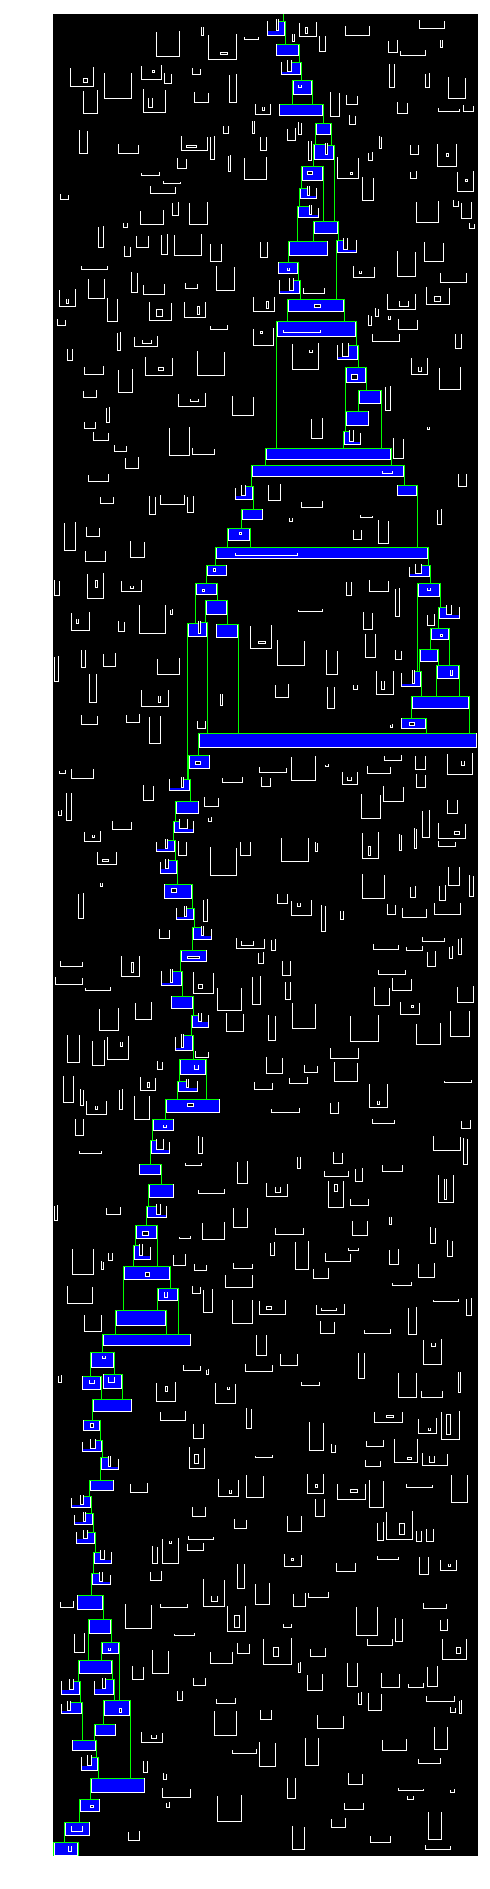

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
ground = read_ground(day(17))
ground = water_flow(ground, water_source)
dpi = 96
rx = range(min(map(first,ground)), max(map(first,ground))+1)
ry = range(min(map(second,ground)), max(map(second,ground)))
def colour(v):
    return {'.': [0,0,0], '#': [255,255,255], '~': [0,0,255], '|': [0,255,0]}[v]
z = np.array([[colour(ground[(x,y)]) for x in rx] for y in ry])
fig = plt.figure(frameon=False, figsize=(len(rx)/dpi, len(ry)/dpi), dpi=dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(z)
plt.imshow(z)

## [Day 18](https://adventofcode.com/2018/day/18) Settlers of The North Pole
Another game of life style automaton, this time in 2D. The rules for evolution of the area are as follows. Note that the area has a boundary: it does not expand or wrap.

In [65]:
clear, trees, yard = '.|#'

def read_setup(data):
    return {(x, y): c 
            for y, row in enumerate(data.splitlines())
            for x, c in enumerate(row)}

def evolve_cell(state, p):
    adj = collections.Counter(state.get(n, '!') for n in neighbours8(*p))
    cell = state[p] 
    return {
        clear: trees if adj[trees] > 2 else cell,
        trees: yard if adj[yard] > 2 else cell,
        yard: yard if min(adj[yard], adj[trees]) > 0 else clear
    }[cell]

def evolve_area(state):
    while True:
        yield state
        state = {p: evolve_cell(state, p) for p in state}

Let's check the worked example .

In [66]:
example_data = r'''\
.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.
'''

areas = evolve_area(read_setup(example_data))
print(render_grid(next(areas)),
      render_grid(next(areas)),
      render_grid(next(areas)), sep='\n\n')

.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.

.......##.
......|###
.|..|...#.
..|#||...#
..##||.|#|
...#||||..
||...|||..
|||||.||.|
||||||||||
....||..|.

.......#..
......|#..
.|.|||....
..##|||..#
..###|||#|
...#|||||.
|||||||||.
||||||||||
||||||||||
.|||||||||


That looks fine. Now let's check the resource value -- the number of wooded acres multiplied by the number of lumberyards -- after 10 minutes.

In [67]:
def area_value(area):
    counts = collections.Counter(area.values())
    return counts[trees] * counts[yard]
    
def resource_value(data, t):
    areas = evolve_area(read_setup(data))
    area = next(its.islice(areas, t, None))
    return area_value(area)

assert resource_value(example_data, 10) == 1147
resource_value(day(18), 10)

604884

For part two, we're asked for the resource value after `1_000_000_000` minutes. Look for a repeating pattern in the data.

In [68]:
def repeated_pattern(data, T):
    '''Evolve the supplied data for up to T minutes, looking for repeats
    
    Returns the repeat, time + time first seen
    Or the final area, 0, 0 if no repeats found
    '''
    seen = {}
    areas = evolve_area(read_setup(data))
    for t, area in its.islice(enumerate(areas), T+1):
        area_hash = render_grid(area)
        if area_hash in seen:
            return area, seen[area_hash], t
        seen[area_hash] = t
    return area, 0, 0

def resource_value(data, T):
    area, tlo, thi = repeated_pattern(data, T)
    if thi > tlo:
        t_left = (T - tlo) % (thi - tlo)
        area = next(its.islice(evolve_area(area), t_left, None))
    return area_value(area)

assert resource_value(example_data, 10) == 1147
resource_value(day(18), 1_000_000_000)

190820

## [Day 19](https://adventofcode.com/2018/day/19) Go With The Flow
Again, we're being asked to model a processor. In fact the processor uses the same rules as Day 16.

In [69]:
def load_program(data, instructions):
    ip, *ops = data.splitlines()
    ip = int(ip.split()[1])
    return ip, [(instructions[op.split()[0]], ints(op)) for op in ops]

def run_program(regs, ip, ops):
    while regs[ip] in range(len(ops)):
        op, args = ops[regs[ip]]
        op(regs, *args)
        yield regs[:]
        regs[ip] += 1

example_program = r'''\
ip 0
seti 5 0 1
seti 6 0 2
addi 0 1 0
addr 1 2 3
setr 1 0 0
seti 8 0 4
seti 9 0 5'''

ops = {op.__name__: op for op in all_ops}
prog = load_program(example_program, ops)
print(*take(run_program([0, 0, 0, 0, 0, 0], *prog)), sep='\n')

[0, 5, 0, 0, 0, 0]
[1, 5, 6, 0, 0, 0]
[3, 5, 6, 0, 0, 0]
[5, 5, 6, 0, 0, 0]
[6, 5, 6, 0, 0, 9]


In [70]:
last(run_program([0, 0, 0, 0, 0, 0], *prog))

[6, 5, 6, 0, 0, 9]

In [71]:
%time last(run_program([0, 0, 0, 0, 0, 0], *load_program(day(19), ops)))

Wall time: 8.24 s


[1568, 892, 256, 893, True, 893]

I had a strong suspicion that this technique wasn't going to get me answer to the second part of the question -- so I set it running whilst also trying to figure out what the [instructions](input/19) were actually doing. 

In [72]:
def rewrite(instructions):
    vars = 'ABCDEF'
    for i, (op, (a, b, c)) in enumerate(instructions):
        syms = {
            addr:'+', addi:'+', mulr:'*', muli:'*', banr:'&', bani:'&', borr:'|', bori:'|',
            gtir:'>', gtri:'>', gtrr:'>', eqir:'==', eqri:'==', eqrr:'=='
        }
        name = op.__name__

        if   name.endswith('rr'): lhs, rhs = vars[a], vars[b]
        elif name.endswith('ir'): lhs, rhs =      a , vars[b]
        elif name.endswith('i' ): lhs, rhs = vars[a], b
        elif name.endswith('r' ): lhs, rhs = vars[a], vars[b]

        if name == 'seti':
            print(f'{vars[c]} = {a}            # {i}')
        elif name == 'setr':
            print(f'{vars[c]} = {vars[a]}        # {i}')
        else:
            print(f'{vars[c]} = {lhs} {syms[op]} {rhs}      # {i}')

rewrite(load_program(day(19), ops)[1])

C = C + 16      # 0
F = 1            # 1
D = 1            # 2
E = F * D      # 3
E = E == B      # 4
C = E + C      # 5
C = C + 1      # 6
A = F + A      # 7
D = D + 1      # 8
E = D > B      # 9
C = C + E      # 10
C = 2            # 11
F = F + 1      # 12
E = F > B      # 13
C = E + C      # 14
C = 1            # 15
C = C * C      # 16
B = B + 2      # 17
B = B * B      # 18
B = C * B      # 19
B = B * 11      # 20
E = E + 2      # 21
E = E * C      # 22
E = E + 12      # 23
B = B + E      # 24
C = C + A      # 25
C = 0            # 26
E = C        # 27
E = E * C      # 28
E = C + E      # 29
E = C * E      # 30
E = E * 14      # 31
E = E * C      # 32
B = B + E      # 33
A = 0            # 34
C = 0            # 35


Here, C is the instruction pointer. Running the program for ~100 iterations and checking the registers, it became clear that B had become fixed at `10551292` and the eventual exit point would be line 16, `C = C * C`.

I refactored the inner block as:

    for F in range(1, B+1):
        for D in range(1, B+1):
            if F*D == B:
                A += F

That is, A (register 0, which part two asks for) is the sum of factors of B. We can figure this out by processing numbers up to the square root of B.

In [73]:
B = 10_551_292
sum(F + B//F for F in range(1, int(math.sqrt(B))) if B % F == 0)

19030032

## [Day 22](https://adventofcode.com/2018/day/22) Mode Maze
Recursive calculations to figure out erosion levels in a cave system. We can use a cache to save time.

In [74]:
depth, target = 6084, (14, 709)

def cache(f):
    _cached = {}
    def get(*v):
        if v not in _cached:
            _cached[v] = f(*v)
        return _cached[v]
    return get

@cache
def erosion_level(x, y, depth):
    return (geological_index(x, y, depth) + depth) % 20183

@cache
def geological_index(x, y, depth):
    if y == 0: return x * 16807
    if x == 0: return y * 48271
    return erosion_level(x-1, y, depth) * erosion_level(x, y-1, depth)

def risk_level(depth, target):
    # It's not entirely clear from the wording, but the worked example
    # shows the target risk level should not be included in the calculation.
    return sum(erosion_level(x, y, depth) % 3
               for x, y in its.product(range(target[0]+1), 
                                       range(target[1]+1))
              ) - erosion_level(*target, depth) % 3
               
    
assert risk_level(510, (10, 10)) == 114
risk_level(depth, target)

10603

## [Day 23](https://adventofcode.com/2018/day/23) Experimental Emergency Teleportation
Nanobots in 3-space. In part one, each has a position and radius. We are asked to find how many are in range of the one with the largest radius, using a city-block distance metric.

In [75]:
example_23 = '''\
pos=<0,0,0>, r=4
pos=<1,0,0>, r=1
pos=<4,0,0>, r=3
pos=<0,2,0>, r=1
pos=<0,5,0>, r=3
pos=<0,0,3>, r=1
pos=<1,1,1>, r=1
pos=<1,1,2>, r=1
pos=<1,3,1>, r=1'''

def in_range_of_strongest(nanobot_data):
    nanobots = array(nanobot_data)
    *strongest, strength = max(nanobots, key=lambda nb: nb[3])
    return ilen(nb for nb in nanobots 
                if manhattan_distance(nb[:3], strongest) <= strength)

assert in_range_of_strongest(example_23) == 7
in_range_of_strongest(day(23))

219

In [76]:
nanobots = array(day(23))
ilen(_ for n, m in its.combinations(nanobots, 2)
     if manhattan_distance(n[:3], m[:3]) < n[3] + m[3])

488381

In [77]:
pprint(sorted(nanobots))

[(-180168520, 58182546, 40115714, 55010545),
 (-156258652, 36020825, 8834591, 99044815),
 (-78161310, 32265063, 35599505, 98859504),
 (-74655591, 32122443, 50332173, 96779160),
 (-67844306, 33259338, 28903087, 96232999),
 (-67553494, 36505258, 45022779, 88750277),
 (-66430503, 34941300, 45963431, 87003981),
 (-64167302, 46378281, 47034701, 97249038),
 (-63165474, 18387928, 37292146, 91264661),
 (-62028086, 21528539, 53755994, 93670915),
 (-61343485, 12001168, 49517071, 98274817),
 (-61252218, 32287741, 43229343, 76438038),
 (-60190033, 35701529, 43657628, 79218005),
 (-58587746, 44705406, 44431432, 87393454),
 (-58012246, 34584684, 32930386, 83699057),
 (-57598647, 40578976, 43530459, 81377193),
 (-56520094, 31246321, 57194711, 84629975),
 (-56064045, 43403864, 37534136, 85966209),
 (-55638187, 37518574, 56580627, 89406133),
 (-54938780, 35400140, 24968048, 89403362),
 (-54663530, 45332635, 58875614, 98540535),
 (-53174929, 41903454, 44530854, 79277986),
 (-52741579, 9875242, 37136273,

## [Day 25](https://adventofcode.com/2018/day/25) Four-Dimensional Adventure
We have points in 4-space, and we're using a Manhattan distance metric. For part one, we have to figure out the number of constellations formed by a set of points: this is the number of connected components of the graph whose nodes are the points, with an edge `PQ` iff `|PQ|` is 3 or less.

In [78]:
def graph(pts, D=3):
    '''Form the graph from the `pts` data
    
    D - add an edge between two points P, Q iff |PQ| <= D
    '''
    pts = array(pts)
    g = {p: set() for p in pts}
    for p, q in its.permutations(pts, 2):
        if manhattan_distance(p, q) <= D:
            g[p].add(q)
    return g

example_25 = '''\
0,0,0,0
 3,0,0,0
 0,3,0,0
 0,0,3,0
 0,0,0,3
 0,0,0,6
 9,0,0,0
12,0,0,0'''

In [79]:
def component(g, v):
    cpt = {v}
    fringe = g[v]
    while fringe:
        cpt |= fringe
        fringe = {w for f in fringe for w in g[f]} - cpt
    return cpt
    
def connected_components(g):
    'Generate the connected components of a graph `g`'
    vs = set(g)
    while vs:
        cpt = component(g, vs.pop())
        yield cpt
        vs -= cpt

assert ilen(connected_components(graph(example_25))) == 2

In [80]:
example_25_b = '''\
1,-1,-1,-2
-2,-2,0,1
0,2,1,3
-2,3,-2,1
0,2,3,-2
-1,-1,1,-2
0,-2,-1,0
-2,2,3,-1
1,2,2,0
-1,-2,0,-2'''

assert ilen(connected_components(graph(example_25_b))) == 8

In [81]:
ilen(connected_components(graph(day(25))))

420